In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    LeakyReLU,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    GlobalAveragePooling2D
)
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import numpy as np
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from matplotlib import pyplot as plt
import glob


In [2]:
# Install the Kaggle API
!pip install kaggle

# Create a Kaggle folder if it doesn't exist
!mkdir -p ~/.kaggle

In [3]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # Change permissions

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
!kaggle datasets download ananthu017/emotion-detection-fer -p /content/ --unzip


Dataset URL: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer
License(s): CC0-1.0
 87% 57.0M/65.2M [00:00<00:00, 126MB/s]
100% 65.2M/65.2M [00:00<00:00, 132MB/s]


In [6]:
train_dir = "/content/train/"
test_dir = "/content/test/"

CLASS_NAMES = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths and parameters
image_shape = (256, 256)  # Resize all images to 224x224
batch_size = 32  # Batch size for loading data

# Initialize ImageDataGenerator for training/validation and test
train_valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    # rotation_range=20,  # Random rotation
    # width_shift_range=0.2,  # Random horizontal shifts
    # height_shift_range=0.2,  # Random vertical shifts
    # shear_range=0.2,  # Random shearing
    # zoom_range=0.2,  # Random zoom
    # horizontal_flip=True,  # Random horizontal flips
    validation_split=0.125  # 10% out of the 80% data for validation (10/80 = 0.125)
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Only rescaling for test data

# Create training data generator (70% of the total dataset)
print("Training Images:")
train_data = train_valid_datagen.flow_from_directory(
    train_dir,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # Specify training subset (70% of total)
)

# Create validation data generator (10% of the total dataset)
print("Validating Images:")
valid_data = train_valid_datagen.flow_from_directory(
    train_dir,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # Specify validation subset (10% of total)
)

# Create test data generator (20% of the total dataset)
print("Test Images:")
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Training Images:
Found 25124 images belonging to 7 classes.
Validating Images:
Found 3585 images belonging to 7 classes.
Test Images:
Found 7178 images belonging to 7 classes.


In [8]:
# Extract class names from the datasets using class_indices
train_class_names = list(train_data.class_indices.keys())
valid_class_names = list(valid_data.class_indices.keys())
test_class_names = list(test_data.class_indices.keys())

# Print class names
print("Training Class Names:", train_class_names)
print("Validation Class Names:", valid_class_names)
print("Test Class Names:", test_class_names)

# Print the number of classes
print("Number of Training Classes:", len(train_class_names))
print("Number of Validation Classes:", len(valid_class_names))
print("Number of Test Classes:", len(test_class_names))

class_names = train_class_names
class_names

Training Class Names: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Validation Class Names: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Test Class Names: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Number of Training Classes: 7
Number of Validation Classes: 7
Number of Test Classes: 7


['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

# Dataset Visualization


In [9]:
plt.figure(figsize =(12,12))

for images, label in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[label[i]])
    plt.axis("off")

AttributeError: 'DirectoryIterator' object has no attribute 'take'

<Figure size 1200x1200 with 0 Axes>

# Modeling


In [20]:
CONFIGURATION = {
    'BATCH_SIZE':32,
    'IM_SIZE': 256,
    'LEARNING_RATE':0.001,
    'N_EPOCHS': 25,
    'DROPOUT_RATE':0.0,
    'REGULARIZATION_RATE':0.0,
    'N_FILTERS':6,
    'KERNEL_SIZE': 3,
    'N_STRIDES': 1,
    'POOL_SIZE' : 2,
    'N_DENSE_1':100,
    'N_DENSE_2': 10,
    'NUM_CLASSES' : 7
}


# Transfer Learning with EfficientNet

In [21]:
backbone = tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3),
)

In [22]:
backbone.trainable = False

In [ ]:
for layer in backbone.layers:
  layer.trainable = False

In [ ]:
# Add global average pooling to reduce dimensionality

from tensorflow.keras.regularizers import l2

x = GlobalAveragePooling2D()(backbone.output)

# # Add fully connected layers with L2 regularization and dropout for better generalization
# x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
# x = BatchNormalization()(x)  # Add BatchNormalization to stabilize training
x = Dropout(0.2)(x)

# Output layer for multi-class classification
x = Dense(7, activation='softmax')(x)


In [ ]:
model = Model(
    inputs = backbone.input,
    outputs = x
)

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Callbacks for early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lambda epoch: 1e-3 * 0.9 ** epoch)


In [ ]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',  # Correct: pass as a string
    metrics=["accuracy"]
)


In [ ]:
# Fit the model using only 30 batches per epoch
history = model.fit(
    train_data,  # Use the full DirectoryIterator
    validation_data=valid_data,  # Full validation dataset
    epochs=20,
    steps_per_epoch=30,  # Use only 30 batches per epoch
    # callbacks=[early_stopping]
)


In [ ]:
model.save("efficientNet_model.keras")

In [10]:
model_path = '/content/efficientNet_model.keras'

In [11]:
model = tf.keras.models.load_model(model_path)


In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 17,711,478 (67.56 MB)

 Trainable params: 12,551 (49.03 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

 Optimizer params: 25,104 (98.07 KB)

# Testing and Evaluation


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Collect all images and true labels from the validation dataset
X_test_all = []
Y_true_all = []

for X_batch, Y_batch in valid_data:  # Iterate through the dataset
    X_test_all.append(X_batch)  # Directly append the numpy arrays
    Y_true_all.append(Y_batch)  # Directly append the numpy arrays

# Concatenate all batches into single arrays
X_test_all = np.concatenate(X_test_all, axis=0)
Y_true_all = np.concatenate(Y_true_all, axis=0)

# Predict on the entire test dataset
Y_pred = model.predict(X_test_all)  # Predictions for the test set
Y_pred_classes = np.argmax(Y_pred, axis=1)  # Convert predicted probabilities to class indices

# Define class labels (if not already defined)
class_labels = CLASS_NAMES  # Replace with your class names

# Function to randomly sample images and check predictions
def plot_random_samples(X_data, Y_true, Y_pred_classes, class_labels, n=10):
    random_indices = np.random.choice(len(X_data), size=n, replace=False)  # Randomly select `n` indices
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(random_indices):
        plt.subplot(1, n, i + 1)
        plt.imshow(X_data[idx].astype("uint8"))  # Assuming images are RGB and in uint8 format
        true_label = class_labels[Y_true[idx]]  # Map integer to class name
        pred_label = class_labels[Y_pred_classes[idx]]  # Map integer to class name
        color = "green" if Y_true[idx] == Y_pred_classes[idx] else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    plt.suptitle("Random Sample Predictions (Correct: Green, Incorrect: Red)", fontsize=16)
    plt.show()

# Choose `n` random samples and visualize
n = 5  # Number of random samples to display
plot_random_samples(X_test_all, Y_true_all, Y_pred_classes, class_labels, n=n)


In [13]:
Y_pred = model.predict(valid_data)
score = model.evaluate(valid_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 215ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 171ms/step - accuracy: 0.0815 - loss: 1.9153
Test loss: 1.880332589149475
Test accuracy: 0.17294281721115112


In [14]:
# Define class names (replace these with actual class names if available)
CLASS_NAMES = CLASS_NAMES# Ensure 'class_names' is defined in your code

# Function to plot accuracy and loss curves
def plot_training_curves(history):
    # Use a dark theme
    plt.style.use('dark_background')
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='cyan')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='cyan')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# Call the function to plot curves
plot_training_curves(history)

NameError: name 'history' is not defined

In [16]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize lists for true labels and predictions
Y_true = []
Y_pred_classes = []

# Loop through validation data to get true labels and predictions
for X_batch, Y_batch in valid_data:
    # True labels
    Y_true.extend(Y_batch)
    # Predictions
    Y_pred = model.predict(X_batch)
    Y_pred_classes.extend(np.argmax(Y_pred, axis=1))  # Convert probabilities to class indices

# Convert lists to NumPy arrays
Y_true = np.array(Y_true)
Y_pred_classes = np.array(Y_pred_classes)


# Define class labels (ensure they match your training labels)
class_labels = CLASS_NAMES  # Replace CLASS_NAMES with your actual class names

# Generate and print the classification report
report = classification_report(Y_true, Y_pred_classes, target_names=class_labels)
print("Classification Report:\n", report)


# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Calculate normalized confusion matrix
conf_matrix_normalized = confusion_matrix(Y_true, Y_pred_classes, normalize='true')

# Plot the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


KeyboardInterrupt: 

# FineTuning EfficientNet

In [17]:
backbone.trainable = False


NameError: name 'backbone' is not defined

In [25]:
from tensorflow.keras.layers import Layer

class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):

    super(CustomConv2D, self).__init__(name = "custom_conv2d")

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding
    )

    self.batch_norm = BatchNormalization()

  def call(self, x, training= True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

In [26]:
input = Input(shape = (256,256,3))

x = backbone(input, training = False)

x = GlobalAveragePooling2D()(x)
x = Dense(CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense(7, activation="softmax")(x)

finetuned_model = Model(input,output)

finetuned_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 8, 8, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │         179,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │              77 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,854,610 (68.11 MB)

 Trainable params: 180,587 (705.42 KB)

 Non-trainable params: 17,674,023 (67.42 MB)

In [27]:
# Compile the model
finetuned_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate  = CONFIGURATION['LEARNING_RATE']/100),  # Correct: pass as a string
    metrics=["accuracy"]
)


In [28]:
# Fit the model using only 30 batches per epoch
history = finetuned_model.fit(
    train_data,  # Use the full DirectoryIterator
    validation_data=valid_data,  # Full validation dataset
    epochs=25,
    steps_per_epoch=30,  # Use only 30 batches per epoch
    # callbacks=[early_stopping]
)


Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.1438 - loss: 2.1111Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 559ms/step - accuracy: 0.1740 - loss: 1.9980 - val_accuracy: 0.1729 - val_loss: 1.9648
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 561ms/step - accuracy: 0.1832 - loss: 1.9967 - val_accuracy: 0.1729 - val_loss: 1.9601
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 828ms/step - accuracy: 0.1651 - loss: 1.9632 - val_accuracy: 0.1729 - val_loss: 1.9571
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 551ms/step - accuracy: 0.1893 - loss: 1.9479 - val_accuracy: 0.1729 - val_loss: 1.9579
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 557ms/step - accuracy: 0.1596 - loss: 1.9851 - val_accuracy: 0.0151 - val_loss: 1.9525
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 563ms/step - accuracy: 0.1699 - loss: 1.9374 - val_accuracy: 0.1729 - val_loss: 1.9509
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 831ms/step - accuracy: 0.1702 - loss: 1.9578 - val_accuracy: 0.1729 - val_loss: 1.9494
Epoch 9/25
30/30 ━━━━━━

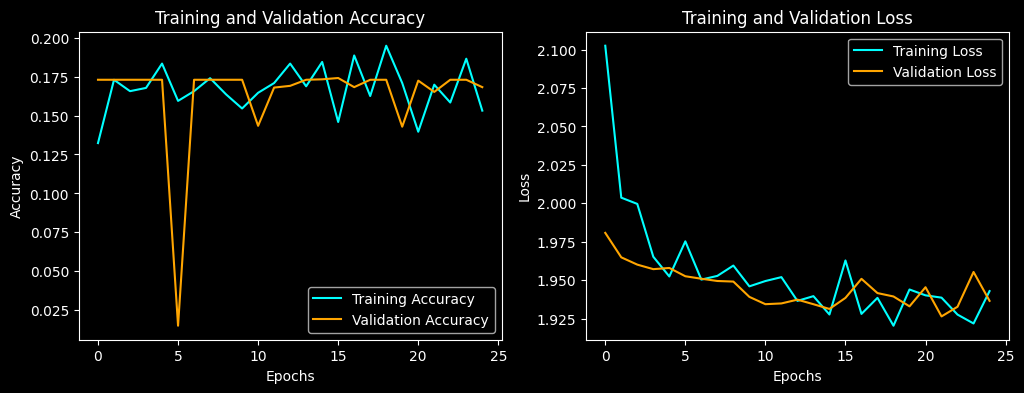

In [29]:
# Define class names (replace these with actual class names if available)
CLASS_NAMES = CLASS_NAMES# Ensure 'class_names' is defined in your code

# Function to plot accuracy and loss curves
def plot_training_curves(history):
    # Use a dark theme
    plt.style.use('dark_background')
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='cyan')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='cyan')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# Call the function to plot curves
plot_training_curves(history)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Collect all images and true labels from the validation dataset
X_test_all = []
Y_true_all = []

for X_batch, Y_batch in valid_data:  # Iterate through the dataset
    X_test_all.append(X_batch)  # Directly append the numpy arrays
    Y_true_all.append(Y_batch)  # Directly append the numpy arrays

# Concatenate all batches into single arrays
X_test_all = np.concatenate(X_test_all, axis=0)
Y_true_all = np.concatenate(Y_true_all, axis=0)

# Predict on the entire test dataset
Y_pred = model.predict(X_test_all)  # Predictions for the test set
Y_pred_classes = np.argmax(Y_pred, axis=1)  # Convert predicted probabilities to class indices

# Define class labels (if not already defined)
class_labels = CLASS_NAMES  # Replace with your class names

# Function to randomly sample images and check predictions
def plot_random_samples(X_data, Y_true, Y_pred_classes, class_labels, n=10):
    random_indices = np.random.choice(len(X_data), size=n, replace=False)  # Randomly select `n` indices
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(random_indices):
        plt.subplot(1, n, i + 1)
        plt.imshow(X_data[idx].astype("uint8"))  # Assuming images are RGB and in uint8 format
        true_label = class_labels[Y_true[idx]]  # Map integer to class name
        pred_label = class_labels[Y_pred_classes[idx]]  # Map integer to class name
        color = "green" if Y_true[idx] == Y_pred_classes[idx] else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    plt.suptitle("Random Sample Predictions (Correct: Green, Incorrect: Red)", fontsize=16)
    plt.show()

# Choose `n` random samples and visualize
n = 5  # Number of random samples to display
plot_random_samples(X_test_all, Y_true_all, Y_pred_classes, class_labels, n=n)
